In [1]:
cd ../analysis/

/home/jlee782/hcomp_paper_seg/analysis


In [2]:
%pylab inline
%load_ext autoreload
%autoreload 2
from withClustAnalysis import *
from hcomp_paper_viz import *

Populating the interactive namespace from numpy and matplotlib


/home/jlee782/.local/lib/python2.7/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [3]:
# Run once
#from qualityBaseline import compute_self_BBvals
# print "generate baseline comparisons"
# compute_self_BBvals(compute_metrics=['simple','area']) #run once
# retreival_df = compute_best_average_heuristics_workers_baselines(rerun_existing=True) #run once

# Effects of clustering

-  if we only pick from the best cluster, if no clustering done then retain the same worker performance as before

In [4]:
from baseline import compute_worker_qualities_against_real_performance

In [5]:
obj_clusters = clusters()

In [6]:
clust_df = pd.read_csv("spectral_clustering_all_hard_obj.csv")
noClust_obj =[obj for obj in object_lst if obj not in clust_df.objid.unique() ]
clustObj = clust_df.objid.unique()

In [7]:
retreival_df= pd.read_csv("pixel_em/individual_worker_performance.csv")
retreival_df["sample_num"]=retreival_df.apply(lambda x:int(x["sample"].split("rand")[-1]),axis=1)
no_cluster_retreival_df = retreival_df[retreival_df["clust"]==-1]
cluster_retreival_df = retreival_df[((retreival_df["clust"]!=-1) & (retreival_df["objid"].isin(clustObj)))|((retreival_df["clust"]==-1) & (~retreival_df["objid"].isin(clustObj)))]

In [8]:
#BAD!
# best_clust_df = compute_best_worker_picking()
# cluster_retreival_df=filter_best_clust(retreival_df,best_clust_df)

In [9]:
def best_cluster(x):
    try:
        return obj_clusters[x["sample"]][str(x["objid"])]
    except(KeyError): #non clustered cases
        return -1

retreival_df["best_clust"]=retreival_df.apply(lambda x: best_cluster(x),axis=1)
cluster_retreival_df = retreival_df[retreival_df["best_clust"]==retreival_df["clust"]]
assert len(cluster_retreival_df.groupby(["sample","objid"]).count())==46*31

In [10]:
retreivalAlgoMap={
    'NumPt':'orange',
    'AreaRatio':'green',
    'AvrgWorker':'blue',
    'BestWorker':'red'
}

For vision, we scan a variety of inclusion thresholds as well as different levels of segmentation granularities. For each object, we pick parameter that yields the best performing Jaccard.

In [11]:
vision = pd.read_csv("pixel_em/vision_only_performance.csv")

# NworkerPerformance = no_cluster_retreival_df.groupby("num_workers").mean()
# for algo in retreivalAlgoMap.keys():
#     algoJ = "J [{}]".format(algo)
#     plt.plot(np.array(NworkerPerformance[algoJ]),label=algo,color=retreivalAlgoMap[algo])

# NworkerPerformance = cluster_retreival_df.groupby("num_workers").mean()
# for algo in  retreivalAlgoMap.keys():
#     algoJ = "J [{}]".format(algo)
#     plt.plot(np.array(NworkerPerformance[algoJ]),linestyle='--',color=retreivalAlgoMap[algo])

# max_vision_k_thresh = vision.loc[vision.groupby(["objid"])['j'].idxmax()].mean()["j"]
# y = np.ones_like(np.array(NworkerPerformance[algoJ]))
# plt.plot(y*max_vision_k_thresh,label="best vision",color="magenta")
# lgd = plt.legend(bbox_to_anchor=(1.04,0.5),loc="center left")    
# #plt.legend(loc="lower left",fontsize=8)    
# plt.ylabel("Jaccard")
# plt.xticks(rotation=50)
# plt.title("Effects of Clustering on Retrieval-Based Algorithms",fontsize=13)
# a = gca().set_xticklabels([0,'5 workers','10 workers','15 workers','20 workers','25 workers','30 workers'])
# plt.savefig("ClusteringEffectOnRetreival.pdf", bbox_extra_artists=(lgd,), bbox_inches='tight')

In [12]:
from tabulate import tabulate

In [13]:
megadfd =[]
for algo in retreivalAlgoMap.keys():
    keys = ['P [{}]'.format(algo), u'R [{}]'.format(algo), 'J [{}]'.format(algo), u'FPR% [{}]'.format(algo),'FNR% [{}]'.format(algo)]
    performance = list(cluster_retreival_df.mean()[keys])
    lst = [algo]
    lst.extend(performance)
    megadfd.append(lst)

In [14]:
megadf = pd.DataFrame(megadfd, columns=["algo","P","R","J","FPR%","FNR%"])

In [15]:
print tabulate(megadf,showindex=False,headers=megadf.columns,tablefmt="latex",floatfmt=".2f")

\begin{tabular}{lrrrrr}
\hline
 algo       &    P &    R &    J &   FPR\% &   FNR\% \\
\hline
 AvrgWorker & 0.91 & 0.92 & 0.84 &   7.94 &   0.52 \\
 NumPt      & 0.87 & 0.92 & 0.82 &   7.86 &   1.10 \\
 BestWorker & 0.95 & 0.95 & 0.90 &   5.23 &   0.17 \\
 AreaRatio  & 0.79 & 0.94 & 0.77 &   5.51 &   2.06 \\
\hline
\end{tabular}


- add MV in this plot 
- leave out clustering for this 

# Comparing MV with EM ; clust v.s. no clust

In [16]:
from analyze_prjs import clust_vs_noclust

In [17]:
algoMap = {
    'GTLSA':'orange',
    "basic":'green',
    "GT":'blue',
    "isoGT":'red',
    "isoGTLSA": 'cyan',
    "isobasic": 'magenta',
    "MV":"black"
}

In [18]:
def avrg_percent_change(clust,noClust):
    return "{:.3f}%".format(np.mean((np.array(clust)-np.array(noClust))/np.array(noClust))*100)

__Comparing cluster v.s. no cluster__

In [19]:
m2m = {"precision":'p','recall':'r', 'jaccard':'j', u'FNR%':'fnr','FPR%':'fpr'}
for metric in ['precision', u'recall', u'jaccard', u'FNR%','FPR%']:
    print "------------"
    print "percent change due to clustering for metric:",metric
    x,MV_noclust,MV_clust=clust_vs_noclust('MV',metric=metric,filtered=False)
    print "{} :{}".format("MV",avrg_percent_change(MV_clust,MV_noclust))
    for algo in algoMap.keys():
        x,algo_noclust,algo_clust=clust_vs_noclust(algo,metric=metric,filtered=False)
        print "{} :{}".format(algo,avrg_percent_change(algo_clust,algo_noclust))

------------
percent change due to clustering for metric: precision
MV :0.369%
GT :0.372%
isobasic :0.344%
basic :0.375%
MV :0.369%
GTLSA :0.202%
isoGT :0.372%
isoGTLSA :-0.329%
------------
percent change due to clustering for metric: recall
MV :1.672%
GT :1.674%
isobasic :1.701%
basic :1.672%
MV :1.672%
GTLSA :1.415%
isoGT :1.674%
isoGTLSA :1.762%
------------
percent change due to clustering for metric: jaccard
MV :2.047%
GT :2.050%
isobasic :1.860%
basic :2.050%
MV :2.047%
GTLSA :1.784%
isoGT :2.050%
isoGTLSA :1.377%
------------
percent change due to clustering for metric: FNR%
MV :-21.145%
GT :-21.164%
isobasic :-21.343%
basic :-21.149%
MV :-21.145%
GTLSA :-17.860%
isoGT :-21.164%
isoGTLSA :-20.256%
------------
percent change due to clustering for metric: FPR%
MV :-8.485%
GT :-8.596%
isobasic :-2.079%
basic :-8.724%
MV :-8.485%
GTLSA :-8.675%
isoGT :-8.596%
isoGTLSA :24.794%


# Greedy Results

In [20]:
greedy_df = pd.read_csv("all_greedy_result.csv")
greedy_df["num_workers"]=greedy_df.apply(lambda x:int(x["sample"].split("workers")[0]),axis=1)
greedy_df["sample_num"] = greedy_df.apply(lambda x: int(x["sample"].split("rand")[-1]),axis=1)
greedy_noclust=greedy_df[greedy_df["clust"]==-1]
best_clust_df=compute_best_worker_picking()
greedy_clust= filter_best_clust(greedy_df,best_clust_df)
assert greedy_noclust.groupby(["sample"])["objid"].count().unique()[0]==8*46

In [21]:
greedyAlgoMap = {
    'GTLSA':'orange',
    "basic":'green',
    "GT":'blue',
    "isoGT":'red',
    "isoGTLSA": 'cyan',
    "isobasic": 'magenta',
    "worker_fraction": 'pink',
    "ground_truth": 'yellow'
}

In [22]:
from analyze_prjs import clust_vs_noclust

# Combined plot

__Comparison between Retreival and families of aggregation based methods__

In [23]:
# !ls -lsd pixel_em/vision_only_performance.csv

In [55]:
vision = pd.read_csv("pixel_em/vision_only_performance_new.csv")

In [56]:
from sample_worker_seeds import sample_specs

In [57]:
data = []
for sample in sample_specs.keys():
    for objid in object_lst:
        worker_ids = json.load(open("pixel_em/{}/obj{}/worker_ids.json".format(sample,objid)))
        worker_ids = [str(i) for i in worker_ids]
        selected = vision[(vision["objid"]==objid)&(vision["worker_id"].isin(worker_ids))]
        Nworkers = int(sample.split("workers")[0])
        assert len(selected)/6==Nworkers
        avrg_j = selected.mean()["j"]
        data.append([Nworkers,sample,objid,avrg_j])

In [58]:
vision_df= pd.DataFrame(data,columns=['Nworkers','sample','objid','J'])

In [59]:
vision_J = np.array(vision_df.groupby("sample").mean().groupby("Nworkers").mean()["J"])

In [60]:
assert len(vision[vision["worker_id"]=="gt"])==46*6

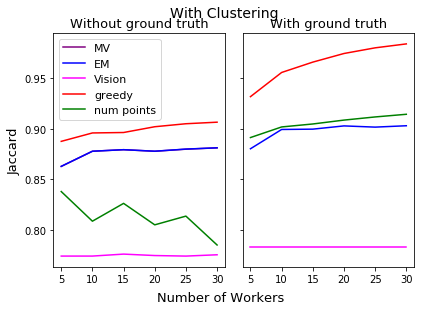

In [91]:
ax1= plt.subplot(121)
plt.text(3.5,1.01,"With Clustering",fontsize=14)
plt.title("Without ground truth",fontsize=13)
x,MV_noclust,MV_clust=clust_vs_noclust("MV",filtered=False)
plt.plot(MV_clust,color="purple",label="MV")
x,best_EM_noclust,best_EM_clust=clust_vs_noclust("basic",filtered=False)
plt.plot(best_EM_clust,color="blue",label="EM")
y = np.ones_like(np.array(NworkerPerformance[algoJ]))
plt.plot(y*vision_J,color="magenta",label="Vision")

best_greedy = np.array(greedy_clust[greedy_clust["algo"]=="worker_fraction"].groupby(["num_workers"]).mean()["j"])
plt.plot(best_greedy,color="red",label="greedy")
plt.ylabel("Jaccard",fontsize=13)
NworkerPerformance = cluster_retreival_df.groupby("num_workers").mean()
# plt.plot(np.array(NworkerPerformance["J [AreaRatio]"]),color="orange",label="AreaRatio")
plt.plot(np.array(NworkerPerformance["J [NumPt]"]),color="green",label="num points")
#plt.plot(np.array(NworkerPerformance["J [AvrgWorker]"]),color="blue",label="average worker")
# plt.ylim(0.78,0.99)
plt.legend(loc="upper left",fontsize=11)

ax2 = plt.subplot(122,sharex=ax1,sharey=ax1)
plt.title("With ground truth",fontsize=13)
ground_truth_greedy = np.array(greedy_clust[greedy_clust["algo"]=="ground_truth"].groupby(["num_workers"]).mean()["j"])
plt.plot(ground_truth_greedy,linestyle="-",color="red",label="Greedy")
plt.plot(np.array(NworkerPerformance["J [BestWorker]"]),linestyle="-",color="green",label="Retrieval")

gt_vision = vision[vision["worker_id"]=="gt"].mean()["j"]
y = np.ones_like(np.array(NworkerPerformance[algoJ]))
plt.plot(y*gt_vision,linestyle="-",label="Vision",color="magenta")

#plt.legend(loc="lower left",fontsize=8)    
# plt.plot(MV_clust,color="purple",label="MV",linestyle='-')
# plt.plot(best_EM_clust,color="blue",label="EM",linestyle='-')
x,best_EM_clust_gt,best_EM_noclust_gt=clust_vs_noclust("basic",filtered=False,ground_truth=True)
plt.plot(best_EM_clust_gt,color="blue",label="EM")
# plt.ylim(0.78,0.99)
# plt.xticks(rotation=50)
#plt.suptitle("Retreival v.s. Aggregation Algorithm Comparison",fontsize=13)
# lgd = plt.legend(bbox_to_anchor=(1.04,0.5),loc="center left")    
plt.xticks([0,1,2,3,4,5])
a = gca().set_xticklabels(['5','10','15','20','25','30'])
# make these tick labels invisible
plt.setp(ax2.get_yticklabels(), visible=False)

plt.text(-3,0.73,"Number of Workers",fontsize=13)
plt.tight_layout()
plt.savefig("Retreival_vs_Aggregation_With_Clustering.pdf", bbox_inches='tight')

In [87]:
ls pixel_em/*.csv

pixel_em/all_PRJ_table.csv
pixel_em/all_PRJ_table_filter_best.csv
pixel_em/basic_full_PRJ_table.csv
pixel_em/GT_full_PRJ_table.csv
pixel_em/GTLSA_full_PRJ_table.csv
pixel_em/individual_worker_performance.csv
pixel_em/isobasic_full_PRJ_table.csv
pixel_em/isoGT_full_PRJ_table.csv
pixel_em/isoGTLSA_full_PRJ_table.csv
pixel_em/MV_full_PRJ_table.csv
pixel_em/vision_only_performance.csv
pixel_em/vision_only_performance_new.csv


In [90]:
pwd

u'/home/jlee782/hcomp_paper_seg/analysis'

In [ ]:
pd.read_csv()

In [88]:
prj_best = pd.read_csv("../basic_ground_truth_full_PRJ_table.csv",index_col=0)
# ground_truth_EM = prj_best.groupby("num_workers").mean()["J [basic]"]

IOError: File withClusterNoBinarySearchResult/basic_ground_truth_full_PRJ_table.csv does not exist

In [85]:
ground_truth_EM

num_workers
5     0.888953
10    0.896165
15    0.897311
20    0.902460
25    0.905905
30    0.907095
Name: J [basic], dtype: float64

In [75]:
!ls -lsd pixel_em/all_PRJ_table_filter_best.csv

644 -rw-rw-r--. 1 jlee782 jlee782 658488 Feb 23 18:58 pixel_em/all_PRJ_table_filter_best.csv


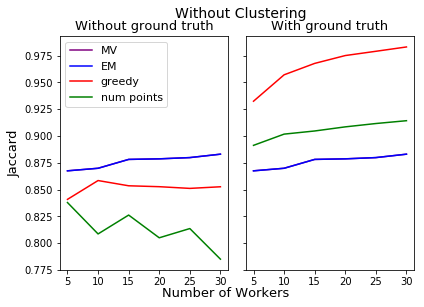

In [65]:
ax1= plt.subplot(121)
plt.text(3.5,1.01,"Without Clustering",fontsize=14)
plt.title("Without ground truth",fontsize=13)
x,MV_noclust,MV_clust=clust_vs_noclust("MV",filtered=False)
plt.plot(MV_noclust,color="purple",label="MV")
x,best_EM_noclust,best_EM_clust=clust_vs_noclust("basic",filtered=False)
plt.plot(best_EM_noclust,color="blue",label="EM")
# y = np.ones_like(np.array(NworkerPerformance[algoJ]))
# plt.plot(y*vision_J,color="magenta",label="Vision")

best_greedy = np.array(greedy_noclust[greedy_noclust["algo"]=="worker_fraction"].groupby(["num_workers"]).mean()["j"])
plt.plot(best_greedy,color="red",label="greedy")
plt.ylabel("Jaccard",fontsize=13)
NworkerPerformance = cluster_retreival_df.groupby("num_workers").mean()
# plt.plot(np.array(NworkerPerformance["J [AreaRatio]"]),color="orange",label="AreaRatio")
plt.plot(np.array(NworkerPerformance["J [NumPt]"]),color="green",label="num points")
#plt.plot(np.array(NworkerPerformance["J [AvrgWorker]"]),color="blue",label="average worker")
# plt.ylim(0.78,0.99)
plt.legend(loc="upper left",fontsize=11)

ax2 = plt.subplot(122,sharex=ax1,sharey=ax1)
plt.title("With ground truth",fontsize=13)
ground_truth_greedy = np.array(greedy_noclust[greedy_noclust["algo"]=="ground_truth"].groupby(["num_workers"]).mean()["j"])
plt.plot(ground_truth_greedy,linestyle="-",color="red",label="Greedy")
plt.plot(np.array(NworkerPerformance["J [BestWorker]"]),linestyle="-",color="green",label="Retrieval")

# gt_vision = vision[vision["worker_id"]=="gt"].mean()["j"]
# y = np.ones_like(np.array(NworkerPerformance[algoJ]))
# plt.plot(y*gt_vision,linestyle="-",label="Vision",color="magenta")

#plt.legend(loc="lower left",fontsize=8)    
plt.plot(MV_noclust,color="purple",label="MV",linestyle='-')
plt.plot(best_EM_noclust,color="blue",label="EM",linestyle='-')
plt.ylim(0.78,0.99)
# plt.xticks(rotation=50)
#plt.suptitle("Retreival v.s. Aggregation Algorithm Comparison",fontsize=13)
# lgd = plt.legend(bbox_to_anchor=(1.04,0.5),loc="center left")    
plt.xticks([0,1,2,3,4,5])
a = gca().set_xticklabels(['5','10','15','20','25','30'])
# make these tick labels invisible
plt.setp(ax2.get_yticklabels(), visible=False)

plt.text(-3,0.75,"Number of Workers",fontsize=13)
plt.tight_layout()
plt.savefig("Retreival_vs_Aggregation_Without_Clustering.pdf", bbox_inches='tight')

__Performance ratio of increase from 5 → 30 workers__

In [35]:
def worker_scaling_ratio(performance):
    return (performance[-1]-performance[0])/performance[0]*100

In [36]:
pchange=[]
for algo in  retreivalAlgoMap.keys():
    if algo!="AreaRatio":
        algoJ = "J [{}]".format(algo)
        performance = np.array(NworkerPerformance[algoJ])
        pchange.append([algo,worker_scaling_ratio(performance)])

In [37]:
pchange.append(["best greedy",worker_scaling_ratio(best_greedy)])
pchange.append(["best EM",worker_scaling_ratio(best_EM_clust)])
pchange.append(["ground truth greedy",worker_scaling_ratio(ground_truth_greedy)])
pchange.append(["MV",worker_scaling_ratio(algo_clust)])
x,algo_noclust,algo_clust=clust_vs_noclust("MV",filtered=False)

In [38]:
pchange=pd.DataFrame(np.array(pchange).T)

In [39]:
# pchange=pchange.transpose()

In [40]:
pchange.columns = pchange.iloc[0]
pchange.reindex(pchange.index.drop(0))

,AvrgWorker,NumPt,BestWorker,best greedy,best EM,ground truth greedy,MV
1,-0.251533707738,-6.30126685667,2.5795546392,1.39680896877,1.64422936203,5.42722004007,-83.9013822372


In [41]:
# pchange.iloc[1]=round(pchange.iloc[1],2)

In [42]:
print tabulate(pchange,showindex=False,tablefmt="latex",floatfmt=".2f")

\begin{tabular}{lllllll}
\hline
 AvrgWorker      & NumPt          & BestWorker   & best greedy   & best EM       & ground truth greedy & MV             \\
 -0.251533707738 & -6.30126685667 & 2.5795546392 & 1.39680896877 & 1.64422936203 & 5.42722004007       & -83.9013822372 \\
\hline
\end{tabular}


__Effects of Clustering__

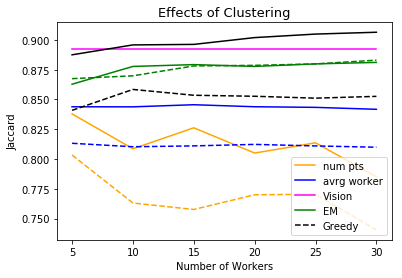

In [93]:
vision = pd.read_csv("pixel_em/vision_only_performance.csv")

NworkerPerformance = cluster_retreival_df.groupby("num_workers").mean()
plt.plot(np.array(NworkerPerformance["J [NumPt]"]),color="orange",label="num pts")#,label="num points [c]")
plt.plot(np.array(NworkerPerformance["J [AvrgWorker]"]),color="blue",label="avrg worker")#,label="average worker [c]")
# plt.plot(np.array(NworkerPerformance["J [BestWorker]"]),linestyle='--',color="red")#,label="best worker [c]")

NworkerPerformance = no_cluster_retreival_df.groupby("num_workers").mean()
plt.plot(np.array(NworkerPerformance["J [NumPt]"]),linestyle='--',color="orange")
plt.plot(np.array(NworkerPerformance["J [AvrgWorker]"]),linestyle='--',color="blue")
# plt.plot(np.array(NworkerPerformance["J [BestWorker]"]),color="red",label="best worker")

max_vision_k_thresh = vision.loc[vision.groupby(["objid"])['j'].idxmax()].mean()["j"]
y = np.ones_like(np.array(NworkerPerformance[algoJ]))
plt.plot(y*max_vision_k_thresh,label="Vision",color="magenta")

algo="basic"
x,algo_noclust,algo_clust=clust_vs_noclust(algo,filtered=False)
plt.plot(algo_noclust,linestyle="--",color = "green")
plt.plot(algo_clust,color = "green",label="EM")

best_greedy = np.array(greedy_clust[greedy_clust["algo"]=="worker_fraction"].groupby(["num_workers"]).mean()["j"])
plt.plot(best_greedy,color="black")
best_noclust_greedy = np.array(greedy_noclust[greedy_noclust["algo"]=="worker_fraction"].groupby(["num_workers"]).mean()["j"])
plt.plot(best_noclust_greedy,color="black",linestyle="--",label="Greedy")

# lgd = plt.legend(bbox_to_anchor=(1.04,0.5),loc="center left")    
lgd = plt.legend(loc="lower right")    
#plt.legend(loc="lower left",fontsize=8)    
plt.ylabel("Jaccard")
plt.xlabel("Number of Workers")
plt.xticks()
plt.title("Effects of Clustering",fontsize=13)
a = gca().set_xticklabels([0,5,10,15,20,25,30])
plt.savefig("Effects_of_clustering.pdf", bbox_extra_artists=(lgd,), bbox_inches='tight')

In [44]:
NworkerPerformance_noclust = no_cluster_retreival_df.groupby("num_workers").mean()
NworkerPerformance_with_clust = cluster_retreival_df.groupby("num_workers").mean()
numpt_no_clust = np.array(NworkerPerformance_noclust["J [NumPt]"])
numpt_with_clust = np.array(NworkerPerformance_with_clust["J [NumPt]"])
bestworker_no_clust = np.array(NworkerPerformance_noclust["J [BestWorker]"])
bestworker_with_clust = np.array(NworkerPerformance_with_clust["J [BestWorker]"])
avrgworker_no_clust = np.array(NworkerPerformance_noclust["J [AvrgWorker]"])
avrgworker_with_clust = np.array(NworkerPerformance_with_clust["J [AvrgWorker]"])

best_greedy_clust = np.array(greedy_clust[greedy_clust["algo"]=="ground_truth"].groupby(["num_workers"]).mean()["j"])
best_noclust_greedy = np.array(greedy_noclust[greedy_noclust["algo"]=="ground_truth"].groupby(["num_workers"]).mean()["j"])
greedy = np.array(greedy_clust[greedy_clust["algo"]=="worker_fraction"].groupby(["num_workers"]).mean()["j"])
noclust_greedy = np.array(greedy_noclust[greedy_noclust["algo"]=="worker_fraction"].groupby(["num_workers"]).mean()["j"])
x,MV_noclust,MV_clust=clust_vs_noclust('MV',metric=metric,filtered=False)

pchange_data = [] 
pchange_data.append(["best worker",avrg_percent_change(bestworker_with_clust,bestworker_no_clust)])
pchange_data.append(["avrg worker",avrg_percent_change(avrgworker_with_clust,avrgworker_no_clust)])
pchange_data.append(["numpt",avrg_percent_change(numpt_with_clust,numpt_no_clust)])
pchange_data.append(["MV",avrg_percent_change(MV_clust,MV_noclust)])
pchange_data.append(["greedy", avrg_percent_change(greedy,noclust_greedy)])
pchange_data.append(["best greedy", avrg_percent_change(best_greedy_clust,best_noclust_greedy)])
pchange_data.append(["EM",avrg_percent_change(algo_clust,algo_noclust)])

In [45]:
pchange_df=pd.DataFrame(np.array(pchange_data).T)

In [46]:
pchange_df

,0,1,2,3,4,5,6
0,best worker,avrg worker,numpt,MV,greedy,best greedy,EM
1,-0.022%,3.996%,5.915%,-8.485%,5.551%,-0.058%,2.050%


In [47]:
pchange_df.columns = pchange_df.iloc[0]
pchange_df.reindex(pchange_df.index.drop(0))

,best worker,avrg worker,numpt,MV,greedy,best greedy,EM
1,-0.022%,3.996%,5.915%,-8.485%,5.551%,-0.058%,2.050%


In [48]:
pchange_df[['numpt','avrg worker','best worker','MV',"EM","greedy","best greedy"]]

,numpt,avrg worker,best worker,MV,EM,greedy,best greedy
0,numpt,avrg worker,best worker,MV,EM,greedy,best greedy
1,5.915%,3.996%,-0.022%,-8.485%,2.050%,5.551%,-0.058%


In [49]:
print tabulate(pchange_df[['numpt','avrg worker','MV',"EM","greedy","best greedy"]],showindex=False,tablefmt="latex",floatfmt=".2f")

\begin{tabular}{llllll}
\hline
 numpt  & avrg worker & MV      & EM     & greedy & best greedy \\
 5.915\% & 3.996\%      & -8.485\% & 2.050\% & 5.551\% & -0.058\%     \\
\hline
\end{tabular}


In [50]:
from PixelEM import *